In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def query_bq(query):
    return pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

# Exploration Outline & Results

**Objective**: Our project is looking to understand the causes of areas recieving broadband access . One cause of this is likely government funding. This notebook explores basic trends in which locations recieve funding from the government to provide broadband access.

## 1. Initial Questions:
* Distribution of years of funding? - We see that the majority of data is from 2017, with significant data from 2016 & 2015. Naturally, I wonder if everything was reported in 2016 & 2015, or if the process for defining a fund changed. Further documentation or exploration may be is needed if we would like to make year to year comparisons. 2017 is used for this exploration
* Distribution of speeds associated with funds? - These funds typically only provide 10/1 speed, significantly lower than normal speeds in the US


## 2. Are these first time broadband installations or upgrades?
* 27% of census blocks recieving broadband funding in 2017 did not recieve broadband as of the 201612 fcc file date. The rest already had some form of broadband
* Funds allocated for upgrades provide faster speeds (up and down) than funds providing broadband in areas which previously didn't have it.

## 3. Comparison of areas that recieved broadband funding vs. those that didn't


### First consider the following
* 72% of all counties recievied broadband funding in 2017
* 1.4% of all census blocks recieved broadband funding 2017

### County Level
* **Income:** Higher in areas not recieving funding
* **Population:** Highest population counties are not recieving funding. Similar distribution excluding these high population counties.
* **Population Density:** Similar trends observed to population
* **Education:**
    * Similar rates of no high school degree in both groups
    * Areas receiving funding have lower rates of college degree holders
* **Rural Urban Divide:** Counties recieving funding have a greater fraction of rural census blocks.

### Census Block Level
* **Rural Urban Divide**: Relationship is much more vivd when looking at census block level
    * Of all blocks recieving funding: 97.4% of them are rural
    * Of all blocks not recieving funding: 53.7% of rural

---------
# 1. Initial Questions:

In [29]:
query = """SELECT year, COUNT(*) as fund_ct
FROM broadband.fund
GROUP BY year
ORDER BY fund_ct DESC
"""
query_bq(query)

,year,fund_ct
0,2017,1049737
1,2016,427451
2,2015,341476
3,2000,3833
4,2014,968
5,2012,633
6,2006,233
7,2011,94
8,2010,21


In [58]:
query = """SELECT CONCAT(CAST(max_down as STRING), '/', CAST(max_up as STRING)) as speed, COUNT(*) as fund_ct
FROM broadband.fund
GROUP BY speed
ORDER BY fund_ct DESC
"""
query_bq(query).dropna()

,speed,fund_ct
0,10/1,1722789
1,100/25,26528
2,25/5,25260
4,1000/500,18865
5,100/20,5404
6,4/1,4100


---
# Part 2 - Are these first broadband installations or upgrades?

In [121]:
# get all census blocks & max offered speed
query = """
SELECT 
    block_code, 
    MAX(max_down) as max_down, 
    MAX(max_up) as max_up
  FROM broadband.fcc
  WHERE file_date = 201612
GROUP BY block_code
"""
df_broadband_blocks = query_bq(query)

In [92]:
df_broadband_blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8958756 entries, 0 to 8958755
Data columns (total 3 columns):
block_code    object
max_down      float64
max_up        float64
dtypes: float64(2), object(1)
memory usage: 205.0+ MB


In [122]:
# get list of all census blocks who got funding for broadband
query = """
SELECT 
    census_block, 
    MAX(max_down) as max_down_fund, 
    MAX(max_up) as max_up_fund,
    COUNT(*) as fund_ct
  FROM broadband.fund
  WHERE year = 2017
GROUP BY census_block
"""
df_fund_blocks = query_bq(query)

In [123]:
broadband_blocks = set(df_broadband_blocks.block_code)
funding_blocks =set(df_fund_blocks.census_block)
funding_no_broadband = funding_blocks.difference(broadband_blocks)
funding_and_broadband = funding_blocks.intersection(broadband_blocks)

print('Blocks with Funding:', len(funding_blocks))
print('Blocks with Broadband:', len(broadband_blocks))
print('Blocks with Funding without previous Broadband:',len(funding_no_broadband))
print('Blocks with Funding and previous Broadband:',len(funding_and_broadband))

Blocks with Funding: 181357
Blocks with Broadband: 8911287
Blocks with Funding without previous Broadband: 49742
Blocks with Funding and previous Broadband: 131615


In [124]:
print("Percent of blocks recieving funding for first time broadband access:", round(len(funding_no_broadband)/len(funding_blocks)*100,2))
print("Percent of blocks recieving funding for updates:", round(len(funding_and_broadband)/len(funding_blocks)*100,2))

Percent of blocks recieving funding for first time broadband access: 27.43
Percent of blocks recieving funding for updates: 72.57


In [126]:
print('Median Download Speed, no previous broadband:',np.median(df_fund_blocks[df_fund_blocks.census_block.isin(funding_no_broadband)].max_down_fund))
print('Median Download Speed, previous broadband:',np.median(df_fund_blocks[df_fund_blocks.census_block.isin(funding_and_broadband)].max_down_fund))
print('Mean Download Speed, no previous broadband:',np.mean(df_fund_blocks[df_fund_blocks.census_block.isin(funding_no_broadband)].max_down_fund))
print('Mean Download Speed, previous broadband:',np.mean(df_fund_blocks[df_fund_blocks.census_block.isin(funding_and_broadband)].max_down_fund))
print('---')
print('Median Upload Speed, no previous broadband:',np.median(df_fund_blocks[df_fund_blocks.census_block.isin(funding_no_broadband)].max_up_fund))
print('Median Upload Speed, previous broadband:',np.median(df_fund_blocks[df_fund_blocks.census_block.isin(funding_and_broadband)].max_up_fund))
print('Mean Upload Speed, no previous broadband:',np.mean(df_fund_blocks[df_fund_blocks.census_block.isin(funding_no_broadband)].max_up_fund))
print('Mean Upload Speed, previous broadband:',np.mean(df_fund_blocks[df_fund_blocks.census_block.isin(funding_and_broadband)].max_up_fund))

Median Download Speed, no previous broadband: 10.0
Median Download Speed, previous broadband: 10.0
Mean Download Speed, no previous broadband: 14.323484863784154
Mean Download Speed, previous broadband: 30.8580314247917
---
Median Upload Speed, no previous broadband: 1.0
Median Upload Speed, previous broadband: 1.0
Mean Upload Speed, no previous broadband: 2.9761899953551305
Mean Upload Speed, previous broadband: 10.827449888210674


In [ ]:
# free up memory
import gc
del [[df_broadband_blocks,df_fund_blocks]]
gc.collect()
df_broadband_blocks=pd.DataFrame()
df_fund_blocks=pd.DataFrame()

---
## Collect Data For Part 3

In [83]:
query = """
SELECT 
  state_county.state_county_code, 
  census_income.census_income_2016,
  census_population_new.pop_2017,
  census_education.no_hs_diploma,
  census_education.bachelor_or_higher,
  fund.max_down_fund,
  fund.max_up_fund,
  fund.fund_ct,
  CASE WHEN fund_ct IS NOT NULL THEN 1 ELSE 0 END AS recieve_fund,
  geography.urban_ct,
  geography.rural_ct,
  geography.road_length,
  geography.land_area
FROM broadband.state_county
LEFT JOIN broadband.census_income
  ON state_county.state_county_code = census_income.state_county_code
LEFT JOIN broadband.census_population_new
  ON state_county.state_county_code = census_population_new.state_county_code
LEFT JOIN broadband.census_education
  ON state_county.state_county_code = census_education.state_county_code
LEFT JOIN (SELECT 
             SUBSTR(census_block,0,5) as state_county_code,
             MAX(max_down) as max_down_fund, 
             MAX(max_up) as max_up_fund,
             COUNT(*) as fund_ct
           FROM broadband.fund
           WHERE year = 2017
           GROUP BY state_county_code) fund
  ON state_county.state_county_code = fund.state_county_code
LEFT JOIN (SELECT 
             SUM(CASE WHEN urban_rural = 'R' THEN 1 ELSE 0 END) AS rural_ct,
             SUM(CASE WHEN urban_rural = 'U' THEN 1 ELSE 0 END) AS urban_ct,
             SUM(total_length) as road_length,
             SUM(land_area) as land_area,
             SUBSTR(block_code,0,5) as state_county_code
           FROM broadband.geography
           GROUP BY state_county_code) geography
  ON state_county.state_county_code = geography.state_county_code
"""
df_county = query_bq(query)

In [84]:
# create density and convert to sq miles
df_county['pop_density_per_sq_mile'] = df_county.pop_2017/df_county.land_area*2.59*10**6

In [85]:
df_county.head()

,state_county_code,census_income_2016,pop_2017,no_hs_diploma,bachelor_or_higher,max_down_fund,max_up_fund,fund_ct,recieve_fund,urban_ct,rural_ct,road_length,land_area,pop_density_per_sq_mile
0,49025,37134,7567,5.0,25.3,NaN,NaN,NaN,0,121,1508,7.335590e+06,1.033409e+10,1.89649
1,49009,34879,1029,4.9,14.5,NaN,NaN,NaN,0,0,753,1.669745e+06,1.805315e+09,1.47626
2,49031,28104,1420,17.0,20.7,NaN,NaN,NaN,0,0,845,2.109264e+06,1.964343e+09,1.87228
3,16067,37542,20729,22.0,14.9,NaN,NaN,NaN,0,975,3288,7.901592e+06,1.960825e+09,27.3804
4,16077,36360,7600,20.8,15.3,NaN,NaN,NaN,0,287,2276,6.238272e+06,3.635908e+09,5.41378


In [86]:
df_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 14 columns):
state_county_code          3143 non-null object
census_income_2016         3112 non-null object
pop_2017                   3140 non-null object
no_hs_diploma              3140 non-null float64
bachelor_or_higher         3140 non-null float64
max_down_fund              2245 non-null object
max_up_fund                2245 non-null object
fund_ct                    2258 non-null object
recieve_fund               3143 non-null int64
urban_ct                   3108 non-null object
rural_ct                   3108 non-null object
road_length                3108 non-null float64
land_area                  3108 non-null float64
pop_density_per_sq_mile    3106 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 343.8+ KB


In [23]:
query = """
SELECT 
  block_code,
  fund_ct,
  CASE WHEN fund_ct IS NOT NULL THEN 1 ELSE 0 END AS recieve_fund,
  max_down_fund,
  max_up_fund,
  urban_rural,
  total_length
FROM broadband.geography
LEFT JOIN (SELECT 
             census_block,
             MAX(max_down) as max_down_fund, 
             MAX(max_up) as max_up_fund,
             COUNT(*) as fund_ct
           FROM broadband.fund
           WHERE year = 2017
           GROUP BY census_block) fund
  ON geography.block_code = fund.census_block
"""
df_block = query_bq(query)

In [24]:
df_block.head()

,block_code,fund_ct,recieve_fund,max_down_fund,max_up_fund,urban_rural,total_length
0,360259710002022,6,1,1000,500,R,9016.542
1,131451204023001,2,1,100,25,R,10101.440
2,131079702001024,4,1,1000,500,R,4917.577
3,371719311022052,1,1,100,25,R,7968.405
4,130759601002036,10,1,100,20,R,7636.539


In [25]:
df_block.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11001482 entries, 0 to 11001481
Data columns (total 7 columns):
block_code       object
fund_ct          object
recieve_fund     int64
max_down_fund    object
max_up_fund      object
urban_rural      object
total_length     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 587.5+ MB


-------
# 3. Comparison of areas that recieved broadband funding vs. those that didn't


In [101]:
len(df_county[df_county.recieve_fund == 1])/len(df_county) 

0.7184218899140948

In [103]:
len(df_block[df_block.recieve_fund == 1])/len(df_block) 

0.014093646655968715

**Income**

In [59]:
print('Median County Income No Funding:',np.median(df_county[df_county.recieve_fund == 0].census_income_2016))
print('Median County Income Funding:',np.median(df_county[df_county.recieve_fund == 1].census_income_2016))
print('---')
print('Mean County Income No Funding:',np.mean(df_county[df_county.recieve_fund == 0].census_income_2016))
print('Mean County Income Funding:',np.mean(df_county[df_county.recieve_fund == 1].census_income_2016))


Median County Income No Funding: 41286.0
Median County Income Funding: 38106.0
---
Mean County Income No Funding: 43719.240373395565
Mean County Income Funding: 39646.48780487805


/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


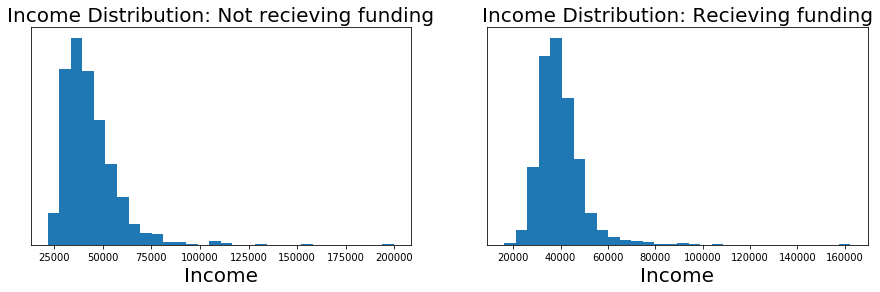

In [42]:
f, ax = plt.subplots(1, 2)
f.set_figheight(4)
f.set_figwidth(15)

ax[0].hist(list(df_county[df_county.recieve_fund == 0].census_income_2016.dropna()),bins=30)
ax[0].set_title('Income Distribution: Not recieving funding',fontsize = 20)
ax[0].set_xlabel('Income', fontsize = 20)
ax[0].set_yticks([])

ax[1].hist(list(df_county[df_county.recieve_fund == 1].census_income_2016.dropna().values),bins=30)
ax[1].set_title('Income Distribution: Recieving funding',fontsize = 20)
ax[1].set_xlabel('Income', fontsize = 20)
ax[1].set_yticks([])

f.show()

**Population**

In [60]:
print('Median County Population No Funding:',np.median(df_county[df_county.recieve_fund == 0].pop_2017))
print('Median County Population Funding:',np.median(df_county[df_county.recieve_fund == 1].pop_2017))
print('---')
print('Mean County Population No Funding:',np.mean(df_county[df_county.recieve_fund == 0].pop_2017))
print('Mean County Population Funding:',np.mean(df_county[df_county.recieve_fund == 1].pop_2017))


Median County Population No Funding: 22669.0
Median County Population Funding: 26564.5
---
Mean County Population No Funding: 159005.724801812
Mean County Population Funding: 81793.88435976961


/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


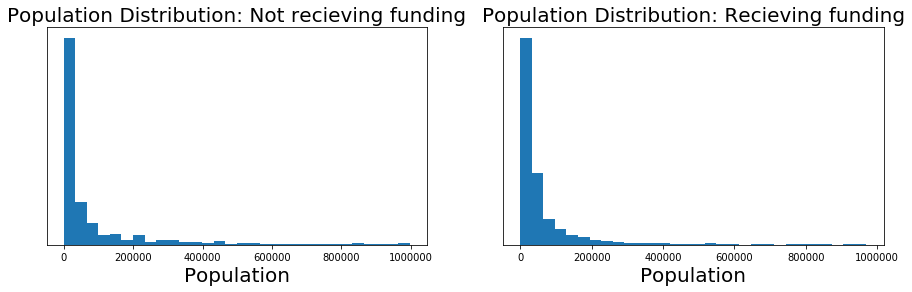

In [47]:
#only plotting counties w/ less than 1 million
f, ax = plt.subplots(1, 2)
f.set_figheight(4)
f.set_figwidth(15)

ax[0].hist(list(df_county[(df_county.recieve_fund == 0) & (df_county.pop_2017 <1000000)].pop_2017.dropna()),bins=30)
ax[0].set_title('Population Distribution: Not recieving funding',fontsize = 20)
ax[0].set_xlabel('Population', fontsize = 20)
ax[0].set_yticks([])

ax[1].hist(list(df_county[(df_county.recieve_fund == 1)& (df_county.pop_2017 <1000000)].pop_2017.dropna()),bins=30)
ax[1].set_title('Population Distribution: Recieving funding',fontsize = 20)
ax[1].set_xlabel('Population', fontsize = 20)
ax[1].set_yticks([])

f.show()

**Population Density**


In [61]:
print('Median County Population Density No Funding:',np.median(df_county[df_county.recieve_fund == 0].pop_density_per_sq_mile))
print('Median County Population Funding:',np.median(df_county[df_county.recieve_fund == 1].pop_density_per_sq_mile))
print('---')
print('Mean County Population Density No Funding:',np.mean(df_county[df_county.recieve_fund == 0].pop_density_per_sq_mile))
print('Mean County Population Density Funding:',np.mean(df_county[df_county.recieve_fund == 1].pop_density_per_sq_mile))


Median County Population Density No Funding: 44.421462868168064
Median County Population Funding: 46.37882255762915
---
Mean County Population Density No Funding: 635.8927211675625
Mean County Population Density Funding: 135.8627317081505


/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


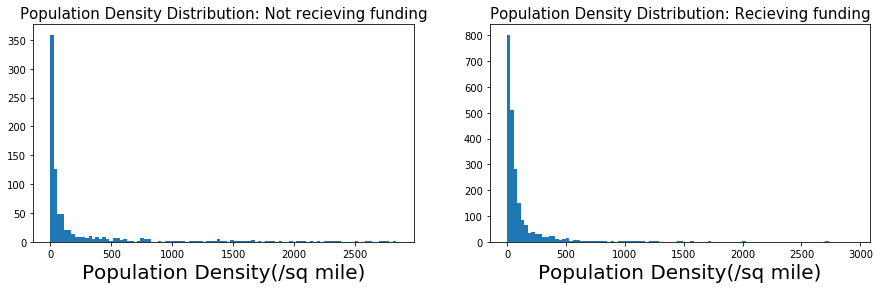

In [66]:
#only plotting counties w/ less than 1 million
f, ax = plt.subplots(1, 2)
f.set_figheight(4)
f.set_figwidth(15)

ax[0].hist(list(df_county[(df_county.recieve_fund == 0)& (df_county.pop_density_per_sq_mile <3000) ].pop_density_per_sq_mile.dropna()),bins=100)
ax[0].set_title('Population Density Distribution: Not recieving funding',fontsize = 15)
ax[0].set_xlabel('Population Density(/sq mile)', fontsize = 20)
#ax[0].set_yticks([])

ax[1].hist(list(df_county[(df_county.recieve_fund == 1)& (df_county.pop_density_per_sq_mile <3000)].pop_density_per_sq_mile.dropna()),bins=100)
ax[1].set_title('Population Density Distribution: Recieving funding',fontsize = 15)
ax[1].set_xlabel('Population Density(/sq mile)', fontsize = 20)
#ax[1].set_yticks([])

f.show()




**Education**


In [107]:
print('Median County No HS Degree (%) No Funding:',np.median(df_county[df_county.recieve_fund == 0].no_hs_diploma.dropna()))
print('Median County No HS Degree (%) Funding:',np.median(df_county[df_county.recieve_fund == 1].no_hs_diploma.dropna()))
print('---')
print('Median County College Degree (%) No Funding:',np.median(df_county[df_county.recieve_fund == 0].bachelor_or_higher.dropna()))
print('Median County College Degree (%) Funding:',np.median(df_county[df_county.recieve_fund == 1].bachelor_or_higher.dropna()))
print('-----------')
print('Mean County No HS Degree (%) No Funding:',np.mean(df_county[df_county.recieve_fund == 0].no_hs_diploma.dropna()))
print('Mean County No HS Degree (%) Funding:',np.mean(df_county[df_county.recieve_fund == 1].no_hs_diploma.dropna()))
print('---')
print('Mean County College Degree (%) No Funding:',np.mean(df_county[df_county.recieve_fund == 0].bachelor_or_higher.dropna()))
print('Mean County College Degree (%) Funding:',np.mean(df_county[df_county.recieve_fund == 1].bachelor_or_higher.dropna()))


Median County No HS Degree (%) No Funding: 12.7
Median County No HS Degree (%) Funding: 12.7
---
Median County College Degree (%) No Funding: 20.3
Median County College Degree (%) Funding: 18.0
-----------
Mean County No HS Degree (%) No Funding: 14.026500566251416
Mean County No HS Degree (%) Funding: 14.24550287992911
---
Mean County College Degree (%) No Funding: 23.059796149490374
Mean County College Degree (%) Funding: 19.9235711120957


/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


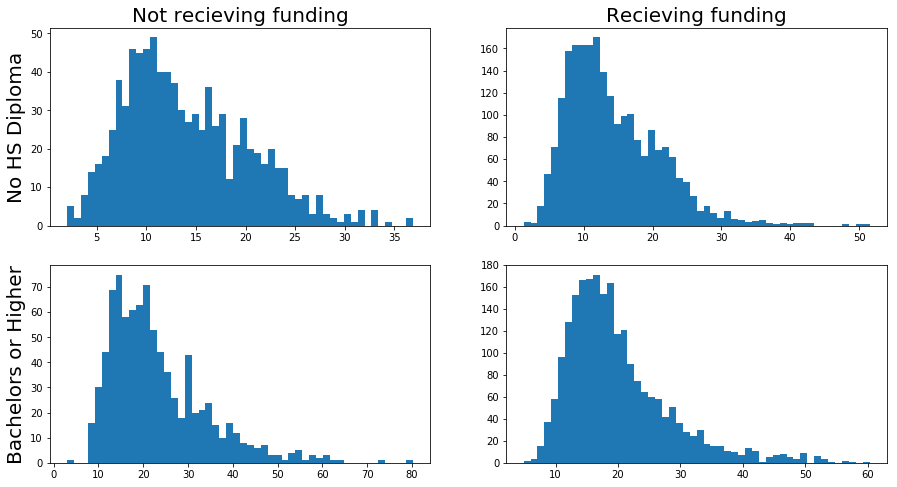

In [75]:
f, ax = plt.subplots(2, 2)
f.set_figheight(8)
f.set_figwidth(15)

ax[0,0].hist(list(df_county[(df_county.recieve_fund == 0)].no_hs_diploma.dropna()),bins=50)
ax[0,0].set_title('Not recieving funding',fontsize = 20)
ax[0,0].set_ylabel('No HS Diploma', fontsize = 20)

ax[0,1].hist(list(df_county[(df_county.recieve_fund == 1)].no_hs_diploma.dropna()),bins=50)
ax[0,1].set_title('Recieving funding',fontsize = 20)

ax[1,0].hist(list(df_county[(df_county.recieve_fund == 0)].bachelor_or_higher.dropna()),bins=50)
ax[1,0].set_ylabel('Bachelors or Higher', fontsize = 20)

ax[1,1].hist(list(df_county[(df_county.recieve_fund == 1)].bachelor_or_higher.dropna()),bins=50)

f.show()

** Rural vs. Urban - County Level **

In [87]:
df_county['rural_pct'] = df_county.rural_ct/(df_county.rural_ct+df_county.urban_ct)

In [88]:
print('Median Rural (%) No Funding:',np.median(df_county[df_county.recieve_fund == 0].rural_pct.dropna()))
print('Median Rural (%) Funding:',np.median(df_county[df_county.recieve_fund == 1].rural_pct.dropna()))
print('---')
print('Mean Rural (%) No Funding:',np.mean(df_county[df_county.recieve_fund == 0].rural_pct.dropna()))
print('Mean Rural (%) Funding:',np.mean(df_county[df_county.recieve_fund == 1].rural_pct.dropna()))


Median Rural (%) No Funding: 0.8025618641046501
Median Rural (%) Funding: 0.8054315133153307
---
Mean Rural (%) No Funding: 0.6922274328426002
Mean Rural (%) Funding: 0.7463564016719518


/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


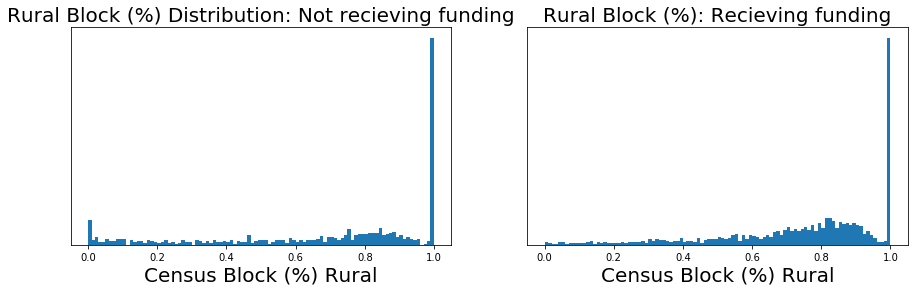

In [90]:
f, ax = plt.subplots(1, 2)
f.set_figheight(4)
f.set_figwidth(15)

ax[0].hist(list(df_county[df_county.recieve_fund == 0].rural_pct.dropna()),bins=100)
ax[0].set_title('Rural Block (%) Distribution: Not recieving funding',fontsize = 20)
ax[0].set_xlabel('Census Block (%) Rural', fontsize = 20)
ax[0].set_yticks([])

ax[1].hist(list(df_county[df_county.recieve_fund == 1].rural_pct.dropna().values),bins=100)
ax[1].set_title('Rural Block (%): Recieving funding',fontsize = 20)
ax[1].set_xlabel('Census Block (%) Rural', fontsize = 20)
ax[1].set_yticks([])

f.show()

** Rural vs. Urban - Block Level **

In [97]:
df_block.head()

,block_code,fund_ct,recieve_fund,max_down_fund,max_up_fund,urban_rural,total_length
0,360259710002022,6,1,1000,500,R,9016.542
1,131451204023001,2,1,100,25,R,10101.440
2,131079702001024,4,1,1000,500,R,4917.577
3,371719311022052,1,1,100,25,R,7968.405
4,130759601002036,10,1,100,20,R,7636.539


In [99]:
print('Rural pct blocks no funding:',len(df_block[(df_block.recieve_fund == 0) &(df_block.urban_rural == 'R')])/len(df_block[(df_block.recieve_fund == 0)]))
print('Rural pct blocks w/ funding:',len(df_block[(df_block.recieve_fund == 1) &(df_block.urban_rural == 'R')])/len(df_block[(df_block.recieve_fund == 1)]))

Rural pct blocks no funding: 0.536996824116615
Rural pct blocks w/ funding: 0.9747889404131543
